In [ ]:
import random
from scipy.ndimage import zoom

class Float(DualTransform):
    def apply(self, image):
        return image.astype(np.float32)

class Contiguous(DualTransform):
    def apply(self, image):
        return np.ascontiguousarray(image)

class Compose:
    def __init__(self, transforms, p=1.0, targets=[['image'],['mask']]):
        assert 0 <= p <= 1
        self.transforms = [Float(always_apply=True)] + transforms + [Contiguous(always_apply=True)]
        self.p = p
        self.targets = targets

    def get_always_apply_transforms(self):
        res = []
        for tr in self.transforms:
            if tr.always_apply:
                res.append(tr)
        return res

    def __call__(self, force_apply=False, **data):
        need_to_run = force_apply or random.random() < self.p
        transforms = self.transforms if need_to_run else self.get_always_apply_transforms()

        for tr in transforms:
            data = tr(force_apply, self.targets, **data)

        return data

def clip(img, dtype, maxval):
    return np.clip(img, 0, maxval).astype(dtype)

class Transform:
    def __init__(self, always_apply=False, p=0.5):
        assert 0 <= p <= 1
        self.p = p
        self.always_apply = always_apply

    def __call__(self, force_apply, targets, **data):
        if force_apply or self.always_apply or random.random() < self.p:
            params = self.get_params(**data)

            for k, v in data.items():
                if k in targets[0]:
                    data[k] = self.apply(v, **params)
                else:
                    data[k] = v

        return data

    def get_params(self, **data):
        """
        shared parameters for one apply. (usually random values)
        """
        return {}

    def apply(self, volume, **params):
        raise NotImplementedError

class DualTransform(Transform):
    def __call__(self, force_apply, targets, **data):
        if force_apply or self.always_apply or random.random() < self.p:
            params = self.get_params(**data)


            for k, v in data.items():
                if k in targets[0]:
                    data[k] = self.apply(v, **params)
                elif k in targets[1]:
                    data[k] = self.apply_to_mask(v, **params)
                else:
                    data[k] = v

        return data

    def apply_to_mask(self, mask, **params):
        return self.apply(mask, **params)

def resize(img, new_shape, interpolation=1, resize_type=0):
    """
    img: [H, W, D, C] or [H, W, D]
    new_shape: [H, W, D]
    interpolation: The order of the spline interpolation (0-5)
    resize_type: what type of resize to use: scikit-image (0) or zoom (1)
    """

    if resize_type == 0:
        new_img = skt.resize(
            img,
            new_shape,
            order=interpolation,
            mode='reflect',
            cval=0,
            clip=True,
            anti_aliasing=False
        )
    else:
        shp = tuple(np.array(new_shape) / np.array(img.shape[:3]))

        if len(img.shape) == 4:
            # Multichannel
            data = []
            for i in range(img.shape[-1]):
                subimg = img[..., i].copy()
                d0 = zoom(subimg, shp, order=interpolation)
                data.append(d0.copy())
            new_img = np.stack(data, axis=-1)
        else:
            new_img = zoom(img.copy(), shp, order=interpolation)

    return new_img

class Resize(DualTransform):
    def __init__(self, shape, interpolation=1, resize_type=1, always_apply=False, p=1):
        super().__init__(always_apply, p)
        self.shape = shape
        self.interpolation = interpolation
        self.resize_type = resize_type

    def apply(self, img):
        return resize(img, new_shape=self.shape, interpolation=self.interpolation, resize_type=self.resize_type)

    def apply_to_mask(self, mask):
        return resize(mask, new_shape=self.shape, interpolation=0, resize_type=self.resize_type)

def get_aug():
    return Compose([
        Resize((2,3,2))
    ]
    )

aug = get_aug()

data = {
    "image": np.ones((5,5,5)),
    "mask": np.zeros((5,5,5))
}

for i in range(10):
    aug_data = aug(**data)
    img, lbl = aug_data['image'], aug_data['mask']
    print(img.shape, lbl.shape, np.max(img), np.max(lbl))


Patches do not divide by the patch shape. Padding image
(0, 0, 0, 0, 0, 0)
torch.Size([8, 12, 1023, 256])


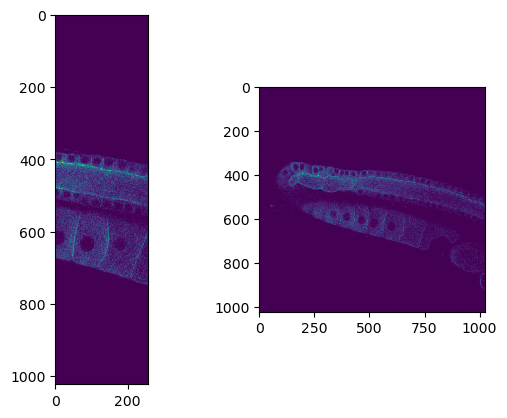

In [219]:
# Creating patches

import skimage
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

im_path = "/Users/ctromans/image-analysis/threedee_nn/data/images/mx85-nd-acqusition-0-ch2.tif"

image = skimage.io.imread(im_path).astype(np.float32)

image = torch.from_numpy(image)

# # 
# image = torch.unsqueeze(image, axis=0)

def generate_patches(image, patch_shape):
    """Generate patches of the desired shape with strides between
    patches.

    Patch shape and stride shape are in order (D, W, H). 
    
    Output tensor with order: (patch, D, W, H)
    """
    # Only non-overlapping patches, for now. 
    stride_shape = patch_shape

    if not torch.is_tensor(image):
        raise TypeError("Input is not a Tensor.")

    # Check that the image dimensions divide cleanly into the patch shape
    # If not, pad the image. 
    if any([
        image.shape[0] % patch_shape[0],
        image.shape[1] % patch_shape[1],
        image.shape[2] % patch_shape[2]]):
        print("Patches do not divide by the image shape. Padding image.")
        image = F.pad(
            image,
            (image.size(2)%patch_shape[2] // 2, image.size(2)%patch_shape[2] // 2,
            image.size(1)%patch_shape[1] // 2, image.size(1)%patch_shape[1] // 2,
            image.size(0)%patch_shape[0] // 2, image.size(0)%patch_shape[0] // 2)
            )
    # Add an extra dimension that will hold the patches
    image = torch.unsqueeze(image, axis=0)
    # Unfold the 1st dimension with size patch_shape[0] with stride_shape[0]
    # Unfold slides along in the provided dimension providing the desired patches
    patches = image.unfold(
        1, patch_shape[0], stride_shape[0]
        ).unfold(
            2, patch_shape[1], stride_shape[1]
            ).unfold(
                3, patch_shape[2], stride_shape[2]
                )
    unfold_shape = patches.size()
    patches = patches.contiguous().view(-1, patch_shape[0], patch_shape[1], patch_shape[2]) 
    return patches, unfold_shape

def reconstruct_patches(patches, unfold_shape):
    """Undo patches. Patch and stride shape must be equal"""
    original_patches = patches.view(unfold_shape)
    depth = unfold_shape[1] * unfold_shape[4]
    width = unfold_shape[2] * unfold_shape[5]
    height = unfold_shape[3] * unfold_shape[6]
    original_patches = original_patches.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
    original_patches = original_patches.view(1, depth, width, height)
    return original_patches

patches, unfold_shape = generate_patches(image, (12, 1023, 256))

reconstruction = reconstruct_patches(patches, unfold_shape)

print(patches.shape)

fig, ax = plt.subplots(1, 2)

# Understanding the dims
# [batch?, z?, ]
ax[0].imshow(patches.numpy()[6, 5,...])
ax[1].imshow(reconstruction[0,20,...])


In [294]:
d = {
    "image": 1,
    "mask": 2
}

eval(**d)

TypeError: eval() takes no keyword arguments

In [14]:
%load_ext autoreload
%autoreload 2
from threedee.utils.data_utils import generate_patches, save_patches
import torch
import skimage
import numpy as np

img = skimage.io.imread("/Users/ctromans/image-analysis/threedee_nn/data/images/mx85-nd-acqusition-0-ch1.tif").astype(np.float32)

img = torch.from_numpy(img)

patches = generate_patches(img, patch_shape=(24, 512, 512), stride_shape=(24, 256, 256))

save_patches(patches, "test_filename.tiff", "hello")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import pandas as pd
import torch
import os
import pathlib

from threedee.utils.data_utils import generate_patches, save_patches

load_data = pd.read_csv("./data/data.csv")

patch_shape = (24, 200, 200)
stride_shape = (24, 100, 100)

save_df = {
    "image": [],
    "label": []
    }

for im, ma in zip(load_data.iloc[:, 0].values, load_data.iloc[:, 2].values):
    image = torch.from_numpy(skimage.io.imread(im).astype(np.float32))
    image_filename = os.path.basename(im)
    image_patches = generate_patches(image, patch_shape=patch_shape, stride_shape=stride_shape)
    image_save_paths = save_patches(image_patches, image_filename, "./patch_data/image")

    save_df["image"].extend(image_save_paths)

    mask = torch.from_numpy(skimage.io.imread(ma).astype(np.float32))
    mask_filename = os.path.basename(ma)
    mask_patches = generate_patches(mask, patch_shape=patch_shape, stride_shape=stride_shape)
    mask_save_paths = save_patches(mask_patches, mask_filename, "./patch_data/labels")

    save_df["label"].extend(mask_save_paths)

save_df = pd.DataFrame.from_dict(save_df, orient="index").transpose()
save_df.to_csv("./patch_data/load_data.csv", index=False)

Patches do not divide by the image shape. Padding image.
Patches do not divide by the image shape. Padding image.


/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-0-ground-truth_patch1.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-0-ground-truth_patch2.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-0-ground-truth_patch3.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-0-ground-truth_patch4.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-0-ground-truth_patch5.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/m

Patches do not divide by the image shape. Padding image.
Patches do not divide by the image shape. Padding image.


/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch4.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch5.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch6.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch7.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch8.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/m

Patches do not divide by the image shape. Padding image.
Patches do not divide by the image shape. Padding image.


/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch1.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch2.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch8.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch9.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch10.tif is a low contrast image
/Users/ctromans/image-analysis/threedee_nn/threedee/utils/data_utils.py:65: UserWarning: ./patch_data/labels/

In [58]:
from torch.autograd import Variable


x = Variable(torch.randn(1, 22, 10, 10))
y = Variable(torch.LongTensor(1, 10, 10).random_(22))

criterion = torch.nn.NLLLoss()

loss = criterion(x, y)

# Binary example
x = torch.sigmoid(Variable(torch.randn(1, 1, 10, 10)))
y = Variable(torch.FloatTensor(1, 1, 10, 10).random_(2))

print(x.shape, y.shape)

criterion = torch.nn.BCELoss()

loss = criterion(x, y)

loss

torch.Size([1, 1, 10, 10]) torch.Size([1, 1, 10, 10])


tensor(0.8241)

In [ ]:
import numpy as np
import sklearn.metrics

np.random.seed(42)
inp = np.random.rand(1, 5)
mask = np.array([0, 0,  1,  1,  1])

out = inp > 0.5
target = mask

out = out.flatten()
target = target.flatten()

out, target, sklearn.metrics.precision_score(target, out, average="binary"), sklearn.metrics.recall_score(target, out, average="binary"), sklearn.metrics.accuracy_score(target, out)

In [16]:
import torch.nn as nn
import torch

class DiceLoss1(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        # Get batch dimension
        num = targets.size(0)
        # Sigmoid of logits
        probability = torch.sigmoid(logits)
        # `view` is basically numpy.reshape
        # Here, we flatten input array (but not the batch dimension)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)

        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        print(intersection)
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
dl = DiceLoss()

torch.manual_seed(42)

inp = torch.rand((2, 5, 5, 5)).unsqueeze(0)
mask = torch.rand((2, 5, 5, 5)).unsqueeze(0)
mask = mask > 0.5

dl(inp, mask)

tensor(136.4800)


tensor(0.4884)

In [120]:
def soft_dice_loss(outputs, targets, per_channel=False, weights=None):
    batch_size, n_channels = outputs.size(0), outputs.size(1)
    print(batch_size, n_channels)
    
    eps = 1e-6
    n_parts = 1
    if per_channel:
        n_parts = batch_size * n_channels
            
    
    print(targets.contiguous().view(n_parts, -1).shape)
    
    dice_target = targets.contiguous().view(n_parts, -1).float()
    dice_output = outputs.contiguous().view(n_parts, -1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    # if weights is not None:
    print(intersection * weights)
    union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1) + eps
    loss = (1 - (2 * intersection + eps) / union).mean()
    return loss

torch.manual_seed(42)
inp = torch.rand(3, 24, 24).unsqueeze(0)
mask = torch.rand(3, 24, 24).unsqueeze(0)

weights = torch.tensor([1, 2, 3])
print(weights.shape)

soft_dice_loss(inp, mask, per_channel=True, weights=weights)

torch.Size([3])
1 3
torch.Size([3, 576])
tensor([132.6456, 281.7210, 433.1403])


tensor(0.5126)

{0: 1.0, 1: 10.624139038057438, 2: 4.455063914674368}
1.0 40.030099237260096 4.455063914674368


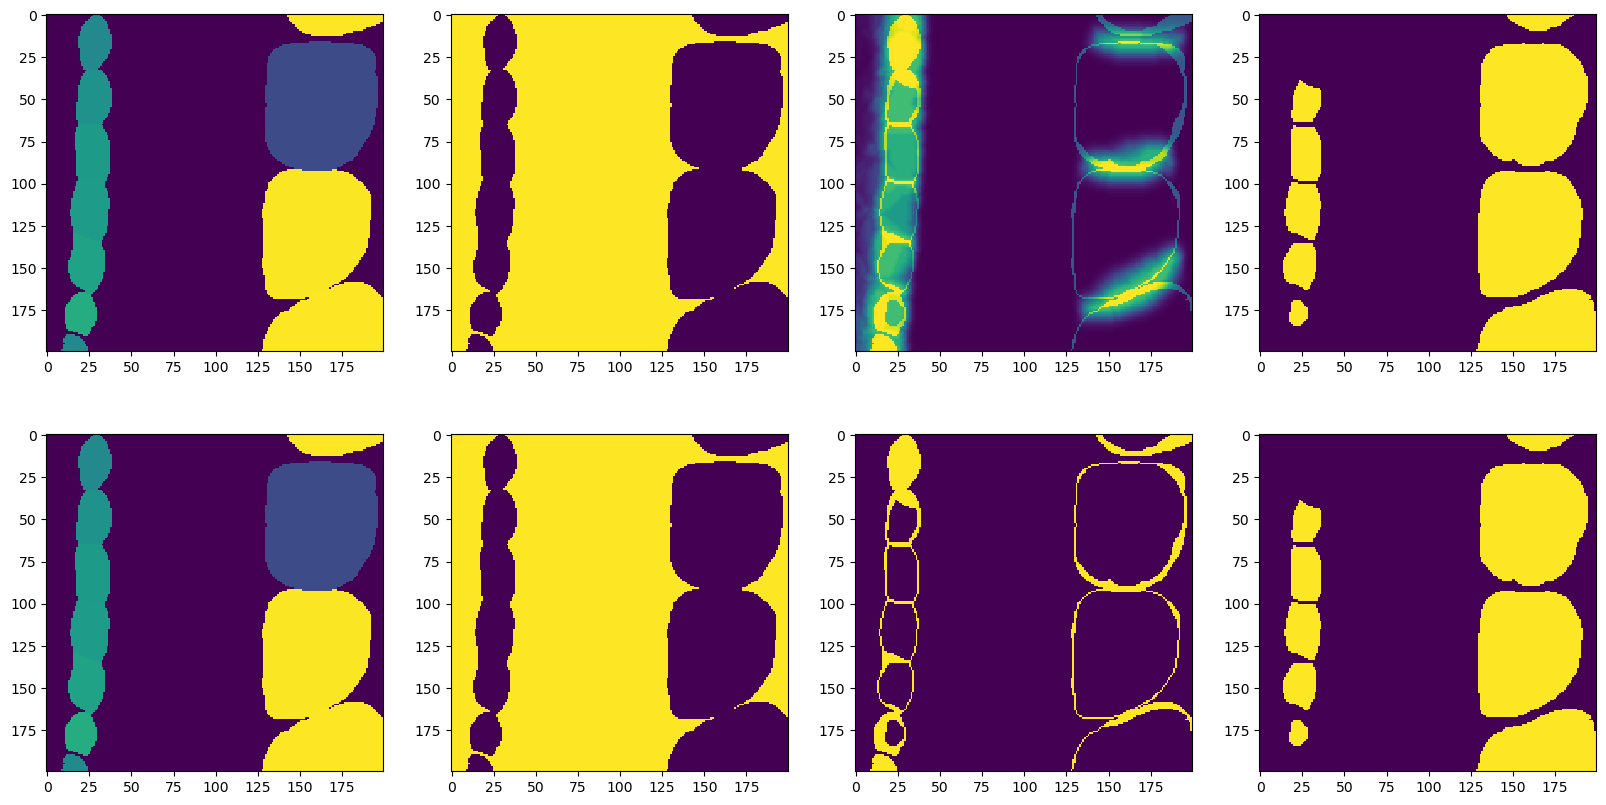

In [354]:
import cv2
import scipy
import matplotlib.pyplot as plt

def edges_and_centroids(labels, connectivity=1, mode="inner", return_initial_border=True, iterations=1, one_hot=True):
    """Calculate the border around objects and then subtract this border from
    the object, reducing the object size"""
    assert iterations > 0, "Iterations must be greater than 0"
    centroids = labels.copy().astype(int)
    for i in range(iterations):
        # Calculate the edges. We use centroids since we will erode them over iterations
        edges = skimage.segmentation.find_boundaries(centroids, connectivity=connectivity, mode=mode)
        # If a pixel was determined to be a boundary of an object, remove it
        centroids[edges > 0.5] = 0
        # Make labels binary
        centroids[centroids > 0.5] = 1
    if return_initial_border:
        edges = skimage.segmentation.find_boundaries(labels, connectivity=connectivity, mode=mode) 

    if one_hot:
        output = [edges, centroids]
        # Find foreground classes
        foreground = np.sum(output, axis=0)
        background = np.zeros_like(labels)
        # Background is where there is no foreground
        background[foreground == 0] = 1
        # Make background the 0th index
        output.insert(0, background)
        return np.stack(output, axis=0)
    else:
        # Bump centroid label up to 2
        centroids[centroids == 1] = 2
        print(centroids.max())
        output = np.stack([edges, centroids], axis=0)
        return np.max(output, axis=0)

def make_consecutive(array):
    """Make a non-contiguous label matrix contiguous"""
    unique = np.unique(array)
    for new_val, unq in enumerate(unique):
        array[array == unq] = new_val
    return array

def one_hot(mask):
    # y = np.array(mask, dtype="int")
    # input_shape = y.shape
    mask = make_consecutive(mask)
    mask = np.array(mask, dtype=int)
    num_classes = np.max(mask) + 1
    return np.moveaxis(np.eye(num_classes)[mask], -1, 0)

def sequential_erode(array, iterations=1):
    array = one_hot(array)
    for label in np.unique(array):
        array[array == label] = skimage.morphology.binary_erosion(array[array == label])
    # undo one-hot
    return np.argmax(array, axis=0)

def auto_class_weights(mask, one_hot=True):
    """For a given mask, determine the weight to give each class
    dependent upon the frequency of a given class.
    
    if one_hot == True, it is assumed that the input mask is 
    shape (class, spatial).

    The most abundant class will be asigned a weight of 1.0
    """
    wc = {}
    if one_hot:
        assert len(mask.shape) == 4, "Are you sure this is a 3D one-hot encoded mask?"
        # Assumes no pixels are shared between classes
        mask = np.argmax(mask, axis=0)
    # Grab classes and their corresponding counts
    unique, counts = np.unique(mask, return_counts=True)
    # For each count, divide it by the total number of pixels to get the frequency
    counts = counts / np.product(mask.shape)
    max_count = max(counts)
    for val, count in zip(unique, counts):
        # Find the weight relative to the max count
        wc[val] = max_count / count
    return wc

def calculate_weight_map(gt_array, centroid_class_index, edge_class_index, labels=None, wc=None, w0=10, sigma=5, background_class=0):
    """
    gt_array: GT pixel classes (eg. background: 0, centroids: 1, cell_edges: 2) with shape (classes, spatial)
    one_hot: True if gt_array is one-hot encoded
    labels: Label map where each object has a unique number. This will allow preservation of the borders defined in GT. 
    edge_class_index: the index on which to find separation borders. If None, will perform on all
    """

    assert np.max(gt_array) == 1, "Expected one-hot encoded ground truth"

    # if not one_hot:

    # if edge_class_index is None:
    #     edge_class_index = slice(0, gt_array.shape[0])

    if wc is None:
        wc = auto_class_weights(gt_array)
        print(wc)
    
    if labels is None:
        labels = skimage.measure.label(gt_array[centroid_class_index])

    # Get total number of objects
    objects = np.unique(labels)
    objects = [obj for obj in objects if obj != background_class]

    w = np.zeros_like(gt_array)
    
    # There exists multiple objects
    if len(objects) > 1:
        distances = np.zeros((len(objects), ) + labels.shape)
        for i, region_id in enumerate(objects):
            # Find the distance transforms for all objects except the iterable
            distances[i,...] = scipy.ndimage.distance_transform_edt(labels != region_id)
        """
        Now, np.sort performs the magic of this function.

        Above, you have defined the inverse distance transforms for each label independently. 
        That is, each object will have a distance transform value of 0 and the non-object pixels
        that are closest to the object of interest have increasing values

        Across all of these object distance maps (axis 0), np.sort will find the lowest to 
        highest distance values. Now, since each object was independently set to False for 
        the distance transforms, all elements inside objects are 0 in the 0th (that is, (0, Z, X, Y)). 
        So, for each object you can find distance to the nearest other object. 

        The same is true for the 1st dimension (1, Z, X, Y), which is the distance to the border
        of the second nearest object.

        Analogy: You're at the bottom of a valley and you want to find the closest valley.
        You climb up a small hill to get a better view and indeed, you spot another valley
        on the other side of the small hill (0th). But now you want to find not a valley, but another
        point that has the same height at the point you are at, so you ascend further up another 
        small hill and now you have a better perspective and you look down around you
        and see another point that was a similar height to your first ascent (1st). (ie. you're 
        incrementally looking for local minima).
        """
        distances = np.sort(distances, axis = 0)
        d1, d2 = distances[0,...], distances[1,...]

        # Determine the separation border, as defined in https://arxiv.org/pdf/1505.04597.pdf
        w[edge_class_index] = w0 * np.exp(-1 * ((d1 + d2) ** 2) / (2 * sigma ** 2)) #* (labels == background_class)
        
    # Array to hold class weights
    wc_x = np.zeros_like(gt_array)
    
    # Compute class weights for each pixel class (background, etc.)
    for pixel_class, weight in wc.items():
        wc_x[pixel_class] = np.where(gt_array[pixel_class] == 1, weight, 0)
    
    # # Add them to the weight map
    wc_x = w + wc_x
    
    return wc_x
    # return w

mask = skimage.io.imread("/Users/ctromans/image-analysis/UNet_3D_C_elegans/patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch79.tif")

gt = edges_and_centroids(mask, mode="inner")

edge = calculate_weight_map(
    gt_array=gt, 
    labels=mask,
    centroid_class_index=2,
    edge_class_index=1,
    w0=30
    )

# print(edge.shape, edge.max())

skimage.io.imsave("edge_emphasis.tiff", edge)
z=12
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0, 0].imshow(mask[z,...])
ax[0, 1].imshow(edge[0,z,...])
ax[0, 2].imshow(edge[1,z,...])
ax[0, 3].imshow(edge[2,z,...])
ax[1, 0].imshow(mask[z,...])
ax[1, 1].imshow(gt[0,z,...])
ax[1, 2].imshow(gt[1,z,...])
ax[1, 3].imshow(gt[2,z,...])
# ax[1].imshow(gt[0,z,...])
# ax[2].imshow(gt[1,z,...])
# ax[3].imshow(gt[2,z,...])


print(edge[0,z,...].max(), edge[1,z,...].max(), edge[2,z,...].max())

In [332]:
print(gt.shape)
np.where(gt[0] == 1, 100, 0).shape

(3, 24, 200, 200)


(24, 200, 200)

In [315]:
gt[0,...]

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[0., 0., 0., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1.

In [115]:
edge[0, 12,...].max(), edge[1, 12,...].max(), edge[40, 12,...].max()

edge[0, 12,...].min(), edge[1, 12,...].min(), edge[40, 12,...].min()

(0.0, 1.4142135623730951, 110.26332119068425)

In [117]:
t = np.array([0, 1, 2, 2, 1])

t != 0

array([False,  True,  True,  True,  True])

[  0. 210. 426. 435. 461. 495. 498. 522. 561. 902. 903. 906.]


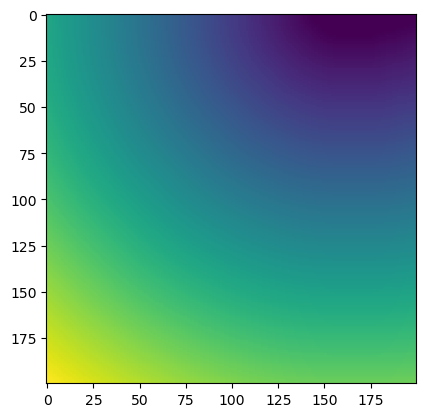

In [148]:
fig, ax = plt.subplots()

print(np.unique(mask[12,...]))

ax.imshow(scipy.ndimage.distance_transform_edt(mask[12,...] != 906))

(11, 200, 200)
(11, 200, 200)


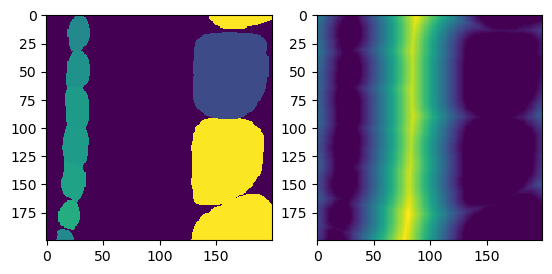

In [145]:
test_dist = weight_map(mask[12,...], None)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(mask[12,...])
ax[1].imshow(test_dist[0,...])

(4, 256, 256)
(4, 256, 256)


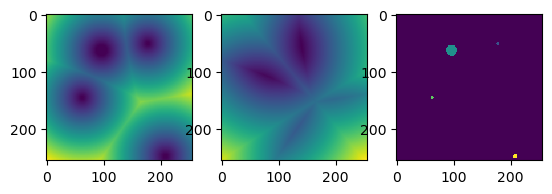

In [192]:
def generate_random_circles(n = 100, d = 256):
    circles = np.random.randint(0, d, (n, 3))
    x = np.zeros((d, d), dtype=int)
    
    for x0, y0, r in circles:
        x += np.fromfunction(lambda x, y: ((x - x0)**2 + (y - y0)**2) <= (r/d*10)**2, x.shape)
    x = np.clip(x, 0, 1)
    x = skimage.measure.label(x)
    return x

gt_mask = generate_random_circles(n=4)

# Get total no. of connected regions in the image and sort them excluding background
region_ids = sorted(np.unique(gt_mask))
region_ids = [region_id for region_id in region_ids if region_id != 0]

# There exists multiple classes
if len(region_ids) > 1: # More than one connected regions
    distances = np.zeros((len(region_ids), ) + gt_mask.shape)
    print(distances.shape)
    for i, region_id in enumerate(region_ids):
        # Find the distance transforms for all objects except the iterable
        distances[i,...] = scipy.ndimage.distance_transform_edt(gt_mask != region_id)
        daf = gt_mask != region_id
    # Sort distance maps from lowest distance to highest for each object
    # Since distances 
    print(distances.shape)
    # This function does all the work. It sorts the calculated distance in 
    # each element of the array, from low to high. 
    # Centers of objects are low, 

    distances = np.sort(distances, axis = 0)

# skimage.io.imsave("test.tiff", distances)

fig, ax = plt.subplots(1, 3)
# ax[0].imshow(distances[0,0,...])
# ax[1].imshow(distances[0,12,...])
ax[0].imshow(distances[0,...])
ax[1].imshow(distances[1,...])
ax[2].imshow(gt_mask)